# DRC Change Detection Using Mosaics

This notebook performs forest change (in the form of creation of new roads) using Planet mosaics as the data source. This notebook follows the workflow, uses the labeled data, and pulls code from the following notebooks, which perform forest change detection using PSOrthoTiles as the data source:
* [DRC Roads Classification](drc_roads_classification.ipynb)
* [DRC Roads Temporal Analysis](drc_roads_temporal_analysis.ipynb)

**NOTE**: This notebook uses the gdal PLMosaic driver to access and download Planet mosaics. Use of the gdal PLMosaic driver requires specification of the Planet API key. This can either be specified in the command-line options, or gdal will try to pull this from the environmental variable `PL_API_KEY`. This notebook assumes that the environmental variable `PL_API_KEY` is set. See the [gdal PLMosaic driver](https://www.gdal.org/frmt_plmosaic.html) for more information.

In [68]:
from functools import reduce
import os
import subprocess
import tempfile

import numpy as np
from planet import api
from planet.api import downloader, filters
import rasterio
from skimage import feature, filters
from sklearn.ensemble import RandomForestClassifier

# load local modules
from utils import Timer
import visual

#uncomment if visual is in development
# import importlib
# importlib.reload(visual)

In [ ]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_classification import get_label_mask, get_unmasked_count \
    load_4band, get_feature_bands, combine_masks, num_valid, perc_masked, bands_to_X, \
    make_same_size_samples, classify_forest, y_to_band, classified_band_to_rgb

## Download Mosaics

In [2]:
# uncomment to see what mosaics are available and to make sure the PLMosaic driver is working
# !gdalinfo "PLMosaic:"

In [3]:
# get mosaic names for July 2017 to March 2018
mosaic_dates = [('2017', '{0:02d}'.format(m)) for m in range(7, 13)] + \
               [('2018', '{0:02d}'.format(m)) for m in range(1, 4)]
mosaic_names = ['global_monthly_{}_{}_mosaic'.format(yr, mo)
                for (yr, mo) in mosaic_dates]

def get_mosaic_filename(mosaic_name):
    return os.path.join('data', mosaic_name + '.tif')

for name in mosaic_names:
    print('{} -> {}'.format(name, get_mosaic_filename(name)))

global_monthly_2017_07_mosaic -> data/global_monthly_2017_07_mosaic.tif
global_monthly_2017_08_mosaic -> data/global_monthly_2017_08_mosaic.tif
global_monthly_2017_09_mosaic -> data/global_monthly_2017_09_mosaic.tif
global_monthly_2017_10_mosaic -> data/global_monthly_2017_10_mosaic.tif
global_monthly_2017_11_mosaic -> data/global_monthly_2017_11_mosaic.tif
global_monthly_2017_12_mosaic -> data/global_monthly_2017_12_mosaic.tif
global_monthly_2018_01_mosaic -> data/global_monthly_2018_01_mosaic.tif
global_monthly_2018_02_mosaic -> data/global_monthly_2018_02_mosaic.tif
global_monthly_2018_03_mosaic -> data/global_monthly_2018_03_mosaic.tif


In [4]:
aoi_filename = 'pre-data/aoi.geojson'

In [5]:
def _gdalwarp(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

# lossless compression of an image
def _compress(input_filename, output_filename):
    commands = ['gdal_translate',
                '-co', 'compress=LZW',
                '-co', 'predictor=2',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

def download_mosaic(mosaic_name,
             output_filename,
             crop_filename,
             overwrite=False,
             compress=True):
    # typically gdalwarp would require `-oo API_KEY={PL_API_KEY}`
    # but if the environmental variable PL_API_KEY is set, gdal will use that
    options = ['-cutline', crop_filename, '-crop_to_cutline',
               '-oo', 'use_tiles=YES']
    
    # use PLMosaic driver
    input_name = 'PLMosaic:mosaic={}'.format(mosaic_name)
    
    # check to see if output file exists, if it does, do not warp
    if os.path.isfile(output_filename) and not overwrite:
        print('{} already exists. Aborting download of {}.'.format(output_filename, mosaic_name))
    elif compress:
        with tempfile.NamedTemporaryFile(suffix='.vrt') as vrt_file:
            options += ['-of', 'vrt']
            _gdalwarp(input_name, vrt_file.name, options)
            _compress(vrt_file.name, output_filename)
    else:
        _gdalwarp(input_name, output_filename, options)

for name in mosaic_names:
    download_mosaic(name, get_mosaic_filename(name), aoi_filename)

data/global_monthly_2017_07_mosaic.tif already exists. Aborting download of global_monthly_2017_07_mosaic.
data/global_monthly_2017_08_mosaic.tif already exists. Aborting download of global_monthly_2017_08_mosaic.
data/global_monthly_2017_09_mosaic.tif already exists. Aborting download of global_monthly_2017_09_mosaic.
data/global_monthly_2017_10_mosaic.tif already exists. Aborting download of global_monthly_2017_10_mosaic.
data/global_monthly_2017_11_mosaic.tif already exists. Aborting download of global_monthly_2017_11_mosaic.
data/global_monthly_2017_12_mosaic.tif already exists. Aborting download of global_monthly_2017_12_mosaic.
data/global_monthly_2018_01_mosaic.tif already exists. Aborting download of global_monthly_2018_01_mosaic.
data/global_monthly_2018_02_mosaic.tif already exists. Aborting download of global_monthly_2018_02_mosaic.
data/global_monthly_2018_03_mosaic.tif already exists. Aborting download of global_monthly_2018_03_mosaic.


## Classify Mosaics into Forest and Non-Forest

To classify the mosaics into forest and non-forest, we use the Random Forests classifier. This is a supervised classification technique, so we need to create a training dataset. The training dataset will be created from one mosaic image and then the trained classifier will classify all mosaic images.

Although we have already performed classification of a 4-band Orthotile into forest and non-forest in [drc_roads_classification](drc_roads_classification.ipnb), the format of the data is different in mosaics, so we need to re-create our training dataset. However, we will use the same label images that were created as a part of that notebook. Additionally, we will pull a lot of code from that notebook.

### Create Label Masks

In [9]:
forest_img = os.path.join('pre-data', 'forestroad_forest.tif')
road_img = os.path.join('pre-data', 'forestroad_road.tif')

In [10]:
forest_mask = get_label_mask(forest_img)
print(get_unmasked_count(forest_mask))

road_mask = get_label_mask(road_img)
print(get_unmasked_count(road_mask))

forest_mask.shape

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


6652509
17219


(3333, 6008)

### Warp Mosaic to Match Label Masks

The label images used to create the label masks were created from the PSOrthoTiles. Therefore, they are in a different projection, have a different transform, and have a different pixel size than the mosaic images. To create the training dataset, we must first match the label and mosaic images so that the pixel dimensions and locations line up. To do this, we warp the mosaic image to match the label image coordinate reference system, bounds, and pixel dimensions. The forest/non-forest labeled images were created in GIMP, which doesn't save georeference information. Therefore, we will pull georeference information from the source image used to create the labeled images, `roads.tif`.

In [14]:
# specify the training dataset mosaic image file
image_file = get_mosaic_filename(mosaic_names[0])
image_file

'data/global_monthly_2017_07_mosaic.tif'

In [70]:
# this is the georeferenced image that was used to create the forest and non-forest label images
label_image = 'pre-data/roads.tif'

In [17]:
# get label image crs, bounds, and pixel dimensions
with rasterio.open(label_image, 'r') as ref:
    dst_crs = ref.crs['init']
    (xmin, ymin, xmax, ymax) = ref.bounds
    width = ref.width
    height = ref.height

print(dst_crs)
print((xmin, ymin, xmax, ymax))
print((width, height))

epsg:32635
(324669.121082206, 113387.27147534769, 343445.6303321145, 123803.11319740933)
(6008, 3333)


In [71]:
# this is the warped training mosaic image we will create with gdal
training_file = os.path.join('data', 'mosaic_training.tif')

In [19]:
# use gdalwarp to warp mosaic image to match label image
!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $image_file $training_file

Using band 4 of source image as alpha.
Creating output file that is 6008P x 3333L.
Processing data/global_monthly_2017_07_mosaic.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### Create Training Datasets

Now that the images match, we create the training datasets from the labels and the training mosaic image.

In [21]:
feature_bands = get_feature_bands(training_file)
print(feature_bands[0].shape)

total_mask = combine_masks(feature_bands)
print(total_mask.shape)

(3333, 6008)
20001980 valid pixels (0.11% masked)
(3333, 6008)


In [22]:
# combine the label masks with the valid data mask and then create X dataset for each label
total_forest_mask = np.logical_or(total_mask, forest_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_forest_mask),
                                            round(perc_masked(total_forest_mask), 2)))
X_forest = bands_to_X(feature_bands, total_forest_mask)

total_road_mask = np.logical_or(total_mask, road_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_road_mask),
                                            round(perc_masked(total_road_mask), 2)))
X_road = bands_to_X(feature_bands, total_road_mask)

6652509 valid pixels (66.78% masked)
17219 valid pixels (99.91% masked)


In [23]:
[X_forest_sample, X_road_sample] = \
    make_same_size_samples([X_forest, X_road], size_percent=100)

print(X_forest_sample.shape)
print(X_road_sample.shape)

(17219, 6)
(17219, 6)


In [24]:
forest_label_value = 0
road_label_value = 1
X_training = np.concatenate((X_forest_sample, X_road_sample), axis=0)
y_training = np.array(X_forest_sample.shape[0] * [forest_label_value] + \
                      X_road_sample.shape[0] * [road_label_value])
    
print(X_training.shape)
print(y_training.shape)

(34438, 6)
(34438,)


### Classify Training Image

Now we will train the classifier to detect forest/non-forest classes from the training data and will run this on the original training mosaic image to see how well it works.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8622399 valid pixels (0.0% masked)
5 seconds
11 seconds


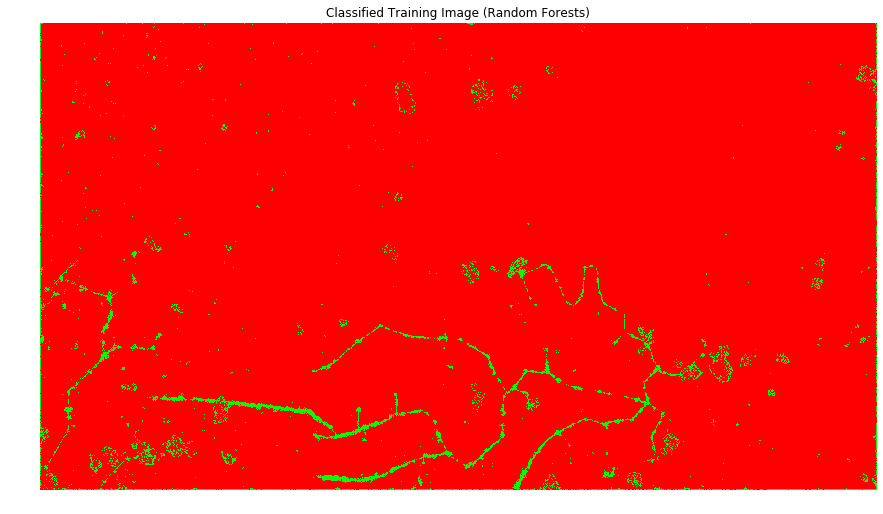

In [72]:
with Timer():
    y_band_rf = classify_forest(image_file, X_training, y_training)
    
visual.plot_image(classified_band_to_rgb(y_band_rf),
                  title='Classified Training Image (Random Forests)',
                  figsize=(15, 15))

### Classification on All Mosaic Images

Now that the classifier is trained, run it on all of the mosaic images. This process takes a while so in this section, if classification has already been run and the classification results have been saved, we will load the cached results instead of rerunning classification. This behavior can be altered by setting `use_cache` to `False`.

In [31]:
classified_bands_file = os.path.join('data', 'classified_mosaic_bands.npz')

def save_to_cache(classified_bands, mosaic_names):
    save_bands = dict((s, classified_bands[s])
                      for s in mosaic_names)
    # masked arrays are saved as just arrays, so save mask for later
    save_bands.update(dict((s+'_msk', classified_bands[s].mask)
                           for s in mosaic_names))
    np.savez_compressed(classified_bands_file, **save_bands)  

def load_from_cache():
    classified_bands = np.load(classified_bands_file)
    scene_ids = [k for k in classified_bands.keys() if not k.endswith('_msk')]

    # reform masked array from saved array and saved mask
    classified_bands = dict((s, np.ma.array(classified_bands[s], mask=classified_bands[s+'_msk']))
                            for s in scene_ids)
    return classified_bands

In [32]:
use_cache = True

if use_cache and os.path.isfile(classified_bands_file):
    print('using cached classified bands')
    classified_bands = load_from_cache()
else:
    with Timer():
        def classify(mosaic_name):
            img = get_mosaic_filename(mosaic_name)
            # we only have two values, 0 and 1. Convert to uint8 for memory
            band = (classify_forest(img, X_training, y_training)).astype(np.uint8)
            return band

        classified_bands = dict((s, classify(s)) for s in mosaic_names)
    
    # save to cache
    save_to_cache(classified_bands, mosaic_names)

using cached classified bands


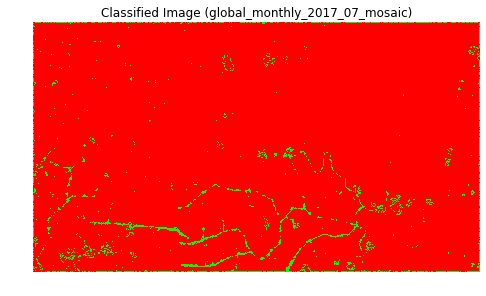

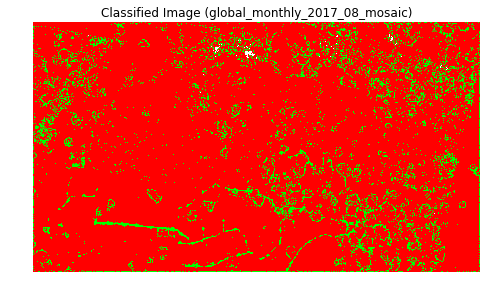

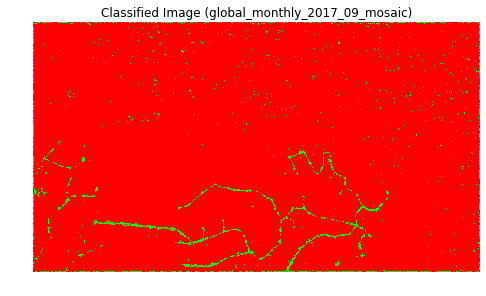

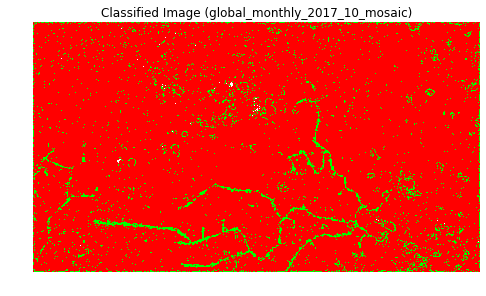

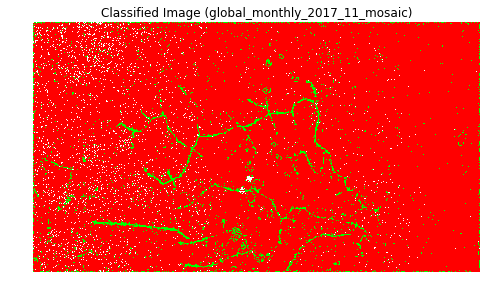

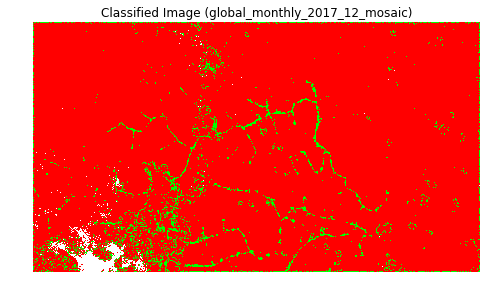

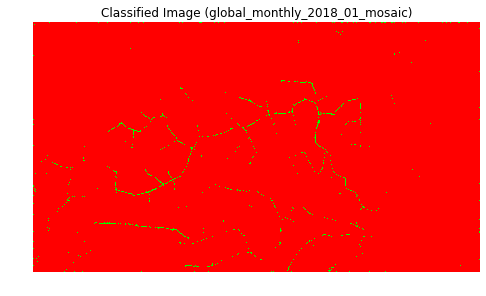

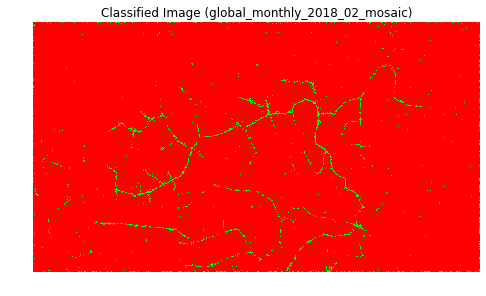

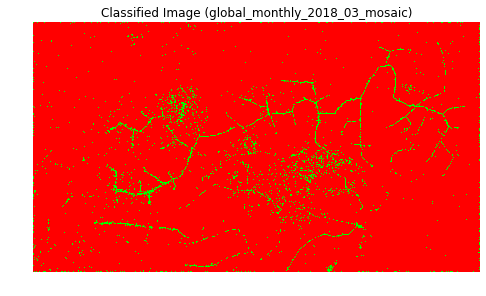

In [33]:
# Decimate classified arrays for memory conservation
def decimate(arry, num=8):
    return arry[::num, ::num].copy()

do_visualize = True # set to True to view images
if do_visualize:
    for mosaic_name, classified_band in classified_bands.items():
        visual.plot_image(classified_band_to_rgb(decimate(classified_band)),
                          title='Classified Image ({})'.format(mosaic_name),
                          figsize=(8, 8))

These classified mosaics look a lot better than the classified PSOrthoTile strips. This bodes well for the quality of our change detection results!

## Identify Change

In this section, we use Random Forest classification once again to detect change in the forest in the form of new roads being built. Once again we need to train the classifier, this time to detect change/no-change. And once again we use hand-labeled images created in the [Temporal Analysis Notebook](drc_roads_temporal_analysis.ipynb) to train the classifier.

### Create Label Masks

The change/no-change label images were created in the [Temporal Analysis Notebook](drc_roads_temporal_analysis.ipynb). The images were created from an image that was created for use with the PSOrthoTiles. Therefore, they are in a different projection, have a different affine transformation, and have different resolution than the classified mosaic bands. Further, the images were created with GIMP, which does not save the georeference information. We already have the classified mosaic bands in memory and so, instead of saving them out and warping each one, we will warp the label images to match the mosaic bands (this is the opposite of what we did in forest/non-forest classification). Therefore, the label images need to be georeferenced and then warped to match the classified mosaic images. Once this is done, the change/no-change label masks can be created.

#### Georeference Labeled Images

The labeled images are prepared in GIMP, so georeference information has not been preserved. First, we will restore georeference information to the labeled images using `rasterio`.

In [34]:
# labeled change images, not georeferenced
change_img_orig = os.path.join('pre-data', 'difference_change.tif')
nochange_img_orig = os.path.join('pre-data', 'difference_nochange.tif')

# georeferenced source image
src_img = os.path.join('pre-data', 'difference.tif')

In [35]:
# destination georeferened label images
change_img_geo = os.path.join('data', 'difference_change.tif')
nochange_img_geo = os.path.join('data', 'difference_nochange.tif')

In [74]:
# get crs and transform from the georeferenced source image
with rasterio.open(src_img, 'r') as src:
    src_crs = src.crs
    src_transform = src.transform

In [ ]:
# create the georeferenced label images
for (label_img, geo_img) in ((change_img_orig, change_img_geo), 
                             (nochange_img_orig, nochange_img_geo)):
    with rasterio.open(label_img, 'r') as src:
        profile = {
            'width': src.width,
            'height': src.height,
            'driver': 'GTiff',
            'count': src.count,
            'compress': 'lzw',
            'dtype': rasterio.uint8,
            'crs': src_crs,
            'transform': src_transform
        }
        
        with rasterio.open(geo_img, 'w', **profile) as dst:
            dst.write(src.read())

#### Match Georeferenced Label Images to Mosaic Images

Now that the label images are georeferenced, we warp them to match the mosaic images.

In [37]:
# get dest crs, bounds, and shape from mosaic image
image_file = get_mosaic_filename(mosaic_names[0])

with rasterio.open(image_file, 'r') as ref:
    dst_crs = ref.crs['init']
    (xmin, ymin, xmax, ymax) = ref.bounds
    width = ref.width
    height = ref.height

print(dst_crs)
print((xmin, ymin, xmax, ymax))
print((width, height))

epsg:3857
(2830219.5489774016, 114168.43998953675, 2848995.3656599834, 124647.6787126414)
(3930, 2194)


In [38]:
# destination matched images
change_img = os.path.join('data', 'mosaic_difference_change.tif')
nochange_img = os.path.join('data', 'mosaic_difference_nochange.tif')

In [40]:
# resample and resize to match mosaic
!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $change_img_geo $change_img

!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $nochange_img_geo $nochange_img

Creating output file that is 3930P x 2194L.
Processing data/difference_change.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3930P x 2194L.
Processing data/difference_nochange.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### Load Label Masks

Now that the label images match the mosaic images, we can load the label masks.

In [41]:
change_mask = get_label_mask(change_img)
print(get_unmasked_count(change_mask))
nochange_mask = get_label_mask(nochange_img)
print(get_unmasked_count(nochange_mask))

97356
3347608


### Get Features from Labels

Create our training dataset from the label masks and the classified mosaic bands.

In [45]:
# combine the label masks with the valid data mask and then create X dataset for each label
classified_bands_arrays = classified_bands.values()
total_mask = combine_masks(classified_bands_arrays)
total_change_mask = np.logical_or(total_mask, change_mask)
print('Change: {} valid pixels ({}% masked)'.format(num_valid(total_change_mask),
                                            round(perc_masked(total_change_mask), 2)))
X_change = bands_to_X(classified_bands_arrays, total_change_mask)

total_nochange_mask = np.logical_or(total_mask, nochange_mask)
print('No Change: {} valid pixels ({}% masked)'.format(num_valid(total_nochange_mask),
                                            round(perc_masked(total_nochange_mask), 2)))
X_nochange = bands_to_X(classified_bands_arrays, total_nochange_mask)

8318844 valid pixels (3.52% masked)
Change: 96208 valid pixels (98.88% masked)
No Change: 3205713 valid pixels (62.82% masked)


In [69]:
# create a training sample set that is equal in size for all categories
# and uses 10% of the labeled change pixels
[X_change_sample, X_nochange_sample] = \
    make_same_size_samples([X_change, X_nochange], size_percent=10)

print(X_change_sample.shape)
print(X_nochange_sample.shape)

(9621, 9)
(9621, 9)


In [64]:
change_label_value = 0
nochange_label_value = 1
X_rf = np.concatenate((X_change_sample, X_nochange_sample), axis=0)
y_rf = np.array(X_change_sample.shape[0] * [change_label_value] + \
                X_nochange_sample.shape[0] * [nochange_label_value])
    
print(X_rf.shape)
print(y_rf.shape)

(19242, 9)
(19242,)


### Classify Change

In [65]:
# NOTE: This relative import isn't working so the following code is directly
# copied from the temporal analysis notebook
# from ipynb.fs.defs.drc_roads_temporal_analysis import classify_change

def classify_change(classified_bands, mask, X_training, y_training):
    clf = RandomForestClassifier()
    
    with Timer():
        clf.fit(X_training, y_training)
    
    X = bands_to_X(classified_bands, total_mask)
    
    with Timer():
        y_pred = clf.predict(X)

    y_band = y_to_band(y_pred, total_mask)
    return y_band

In [66]:
with Timer():
    y_band_rf = classify_change(classified_bands_arrays, total_mask, X_rf, y_rf)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
4 seconds
5 seconds


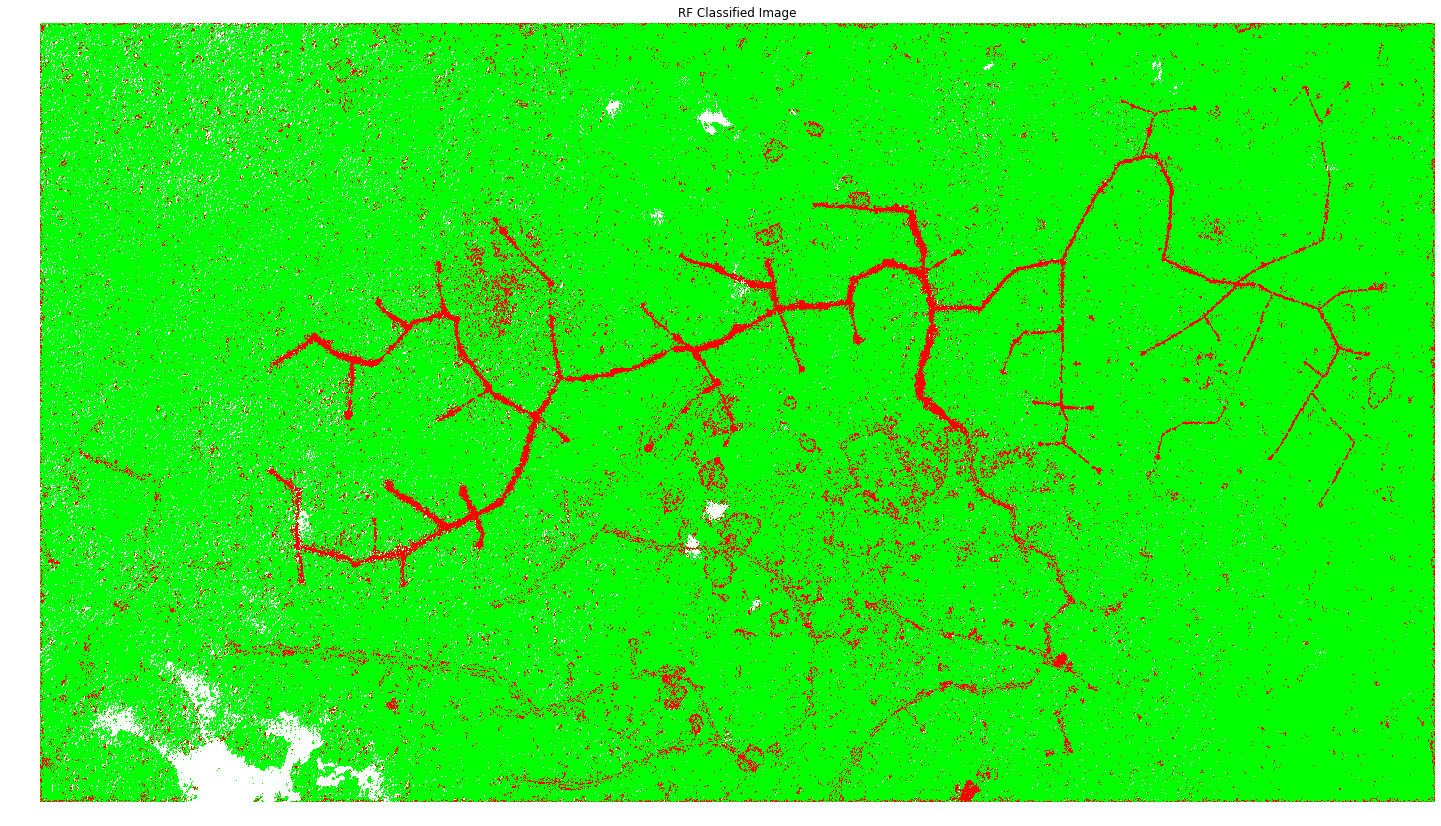

In [67]:
visual.plot_image(classified_band_to_rgb(y_band_rf), title='RF Classified Image', figsize=(25, 25))

The results look pretty good! With a little clean up, we could have a pretty cut and dry change classification. To achieve these results, we used only 10% of the pixels manually labeled as 'change' as the training dataset. In general, the results here are a bit cleaner than the results from PSOrthoTiles, but there is more structure to the erroneous change detection - we can see outlines of the unchanged roads as well as clouds.